<a href="https://colab.research.google.com/github/techi-me/Dog-Breed-Identification-Mobilenet-V2/blob/main/dogbreed_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog Breed Identification

In [ ]:
#Importing required libraries.
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from IPython.display import Image
import os
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imread

In [ ]:
#Check GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#Importing dog breed datasets's labels
labels_csv = pd.read_csv("DogDataset/labels.csv")
print (labels_csv.describe())             #labels descriptions   
print (labels_csv.head())                 #Top 5 rows of labels csv


                                      id               breed
count                              10222               10222
unique                             10222                 120
top     2b5c0c29ae9783290d924b2f8d365466  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [ ]:
#Images in each breed
labels_csv["breed"].value_counts().median()

82.0

In [ ]:
#Creating list of file names from the labels's csv file
filename = []
for fname in labels_csv["id"]:
    path = "DogDataset/train/" + fname + ".jpg"
    filename.append(path)

In [ ]:
#Verify the all the labels in csv file
if len(os.listdir("DogDataset/train/")) == len(filename):
    print ("Verified all files.")
else:
    print ("Missing some files!!")

Verified all files.


In [ ]:
labels = labels_csv["breed"].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
if len(labels) == len(filename):
    print ("All labels verified")
else:
    print ("Missing some files")

All labels verified


In [ ]:
#uniques labels
unique_breeds = np.unique(labels)
boolean_labels = [label == unique_breeds for label in labels]

In [ ]:
# Creating validation set
x = filename
y = boolean_labels

In [ ]:
x_train , x_val, y_train, y_val = train_test_split(x[:1000],
                                                   y[:1000],
                                                   test_size = 0.2,
                                                   random_state=42)
len(x_train), len(x_val), len(y_train), len(y_val)

(800, 200, 800, 200)

# Preprocessing Images 
## take an image filepath
## use tensflow to read file and save it to a image
## turn our image to tensor
## normalize our image 
## resize the image to be a shape of (224,224)
## return the modified image

In [ ]:
IMAGE_SIZE = 224

def pre_process_image(image_path):
    #read in a image file
    image = tf.io.read_file(image_path)
    #turn image to numerical tensor with 3 color RGB
    image = tf.image.decode_jpeg(image, channels=3)
    #convert the color channel value from 0-255 to 0-1 value
    image = tf.image.convert_image_dtype(image, tf.float32)
    #resize our image to our desired value (244,244)
    image = tf.image.resize(image, size = [IMAGE_SIZE, IMAGE_SIZE])
    #return the image
    return image

In [ ]:
#turning our data into batches
def get_image_label(image_path,label):
    image = pre_process_image(image_path)
    
    return image, label

In [ ]:
BATCH_SIZE = 32

def create_data_batches(x, y = None, batch_size = BATCH_SIZE, valid_data = False, test_data = False):

  # If the data is the test data set, we don't have labels
    if test_data:
        print('Creating test data batches . . . .')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))   # Only filepaths no labels
        data_batch = data.map(pre_process_image).batch(BATCH_SIZE)
        return data_batch

    # If the data is a valid data set, we don't need to shuffle it
    elif valid_data:
        print("Creating validation data batches . . . ")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
        data_batch = data.map(get_image_label).batch(BATCH_SIZE) #Also preprocesses the images 
        return data_batch

    else:
        print("Creating training data batches . . . . ")    
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
    # Shuffling the pathnames before mapping and processing 
        data = data.shuffle(buffer_size = len(x))

        data = data.map(get_image_label)

        data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [ ]:
train_data = create_data_batches(x_train, y_train)
valid_data = create_data_batches(x_val, y_val, valid_data = True)

Creating training data batches . . . . 
Creating validation data batches . . . 


In [ ]:
#Building model
INPUT_SHAPE = [None, IMAGE_SIZE,IMAGE_SIZE,3]

OUTPUT_SHAPE= len(unique_breeds)

# Setup model URL from TensorFlow HUB

MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [ ]:
def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
    print("Building model with: ", MODEL_URL)

    model = tf.keras.Sequential([hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
                               tf.keras.layers.Dense(units = OUTPUT_SHAPE,
                                                    activation = "softmax")
                               ])
  #Compile the model
    model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ["accuracy"]
  )

  #Build the model
    model.build(INPUT_SHAPE)
    return model

In [ ]:

model = create_model()
model.summary()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_9 (KerasLayer)   multiple                  5432713   
_________________________________________________________________
dense_9 (Dense)              multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import datetime

# Create a function to build a tensorboard callback
def create_tensorboard_callback():
    logdir = os.path.join("DogDataset\logs",
                         datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  
  return tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience=3)

In [ ]:
NUM_EPOCHS = 100 

In [ ]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
    model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=valid_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[tensorboard, early_stopping])
  
  return model

In [ ]:
# Fitting the model to the data
model = train_model()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Train for 25 steps, validate for 7 steps
Epoch 1/100
25/25 [==============================] - 15s 581ms/step - loss: 4.5992 - accuracy: 0.1213 - val_loss: 3.3726 - val_accuracy: 0.2700
Epoch 2/100
25/25 [==============================] - 10s 412ms/step - loss: 1.6291 - accuracy: 0.6888 - val_loss: 2.0900 - val_accuracy: 0.5150
Epoch 3/100
25/25 [==============================] - 11s 434ms/step - loss: 0.5570 - accuracy: 0.9413 - val_loss: 1.6146 - val_accuracy: 0.5600
Epoch 4/100
25/25 [==============================] - 10s 405ms/step - loss: 0.2475 - accuracy: 0.9925 - val_loss: 1.4178 - val_accuracy: 0.6000
Epoch 5/100
25/25 [==============================] - 10s 406ms/step - loss: 0.1442 - accuracy: 0.9975 - val_loss: 1.3456 - val_accuracy: 0.6000
Epoch 6/100
25/25 [==============================] - 10s 417ms/step - loss: 0.0988 - accuracy: 0.9987 - val_loss: 1.2906 - val_accuracy: 0.6200
E

In [ ]:
predictions = model.predict(valid_data, verbose = 1)
predictions

7/7 [==============================] - 2s 351ms/step


array([[1.2727468e-03, 5.1453814e-04, 1.0070984e-03, ..., 7.5368611e-05,
        3.9164534e-05, 8.8568806e-04],
       [1.0327762e-03, 1.0335821e-03, 3.0556522e-02, ..., 6.1010639e-04,
        4.6906397e-03, 2.7144441e-04],
       [2.2413667e-05, 1.4496180e-04, 6.9175735e-06, ..., 5.6408253e-04,
        2.7295700e-04, 9.5534563e-04],
       ...,
       [4.1537396e-06, 6.9146354e-06, 3.0724608e-05, ..., 3.1761294e-06,
        2.6940979e-05, 8.4720778e-06],
       [1.8990777e-03, 5.2246753e-05, 2.8895392e-04, ..., 5.8506888e-05,
        5.2007388e-05, 8.5955616e-03],
       [3.6104469e-04, 6.9289381e-05, 6.7716645e-04, ..., 1.9245310e-03,
        1.9206399e-04, 8.1228049e-05]], dtype=float32)

In [ ]:
def get_pred_label(prediction_probabilities):
    return unique_breeds[np.argmax(prediction_probabilities)]

In [ ]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
    images = []
    labels = []
  # Loop through unbatched data
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])
    return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(valid_data)

In [ ]:
import matplotlib.pyplot as plt
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  
  # Get the pred label
    pred_label = get_pred_label(pred_prob)
  
  # Plot image & remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
    if pred_label == true_label:
        color = "green"
      else:
        color = "red"

    plt.title("{} {:2.0f}% {}".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

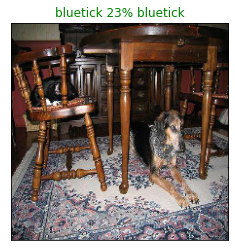

In [ ]:
plot_pred(predictions, val_labels, val_images, 3)